# Tutorial: Cut Relaxation with MellowGate

Welcome to this tutorial on MellowGate, a Python library designed to make discrete optimization problems differentiable. In this tutorial, we will explore how MellowGate can be used to relax discrete decisions, enabling gradient-based optimization techniques to be applied to problems that involve hard thresholds or categorical choices.

## Why Discrete Optimization Matters
Discrete optimization problems involve decision variables that take on discrete values, such as binary choices or categorical options. These problems are common in fields like operations research, machine learning, and control systems. However, the discrete nature of these decisions makes them non-differentiable, posing challenges for gradient-based optimization methods.

## The Role of Cut Relaxation
Cut relaxation is a technique that approximates discrete decisions with continuous functions. By relaxing the hard boundaries of discrete decisions, we can compute gradients and apply optimization algorithms. This tutorial focuses on three methods for cut relaxation:
1. **Hard Cuts**: The baseline method with strict thresholds.
2. **Sigmoid Relaxation**: A smooth approximation using the sigmoid function.
3. **Stochastic Relaxation**: A probabilistic approach based on logits.

## Defining a Discrete Problem

Discrete optimization problems involve decision variables that can take on a finite set of values. For example, in a binary decision problem, the variable can only be 0 or 1. These problems are common in optimization tasks where the goal is to find the best combination of discrete choices to maximize or minimize an objective function.

### What Are Logits?
Logits are unnormalized scores or raw predictions produced by a model. They are often used as inputs to compute probabilities. For example, in a classification problem, logits represent the relative confidence of the model for each class before normalization.

### How Logits Relate to Probabilities
Logits can be transformed into probabilities using various methods. The most common method is the softmax function, which ensures that the probabilities are non-negative and sum to 1. Mathematically, the softmax function is defined as:
$$
P(y_i) = \frac{\exp(z_i)}{\sum_{j=1}^n \exp(z_j)}
$$
where:
- $z_i$ are the logits for each class $i$.
- $P(y_i)$ is the probability of class $i$.

Other methods include:
- **Sigmoid Function**: Often used for binary classification, where the probability is computed as:
  $$
  P(y) = \frac{1}{1 + \exp(-z)}
  $$
- **Temperature Scaling**: Adjusting the sharpness of the distribution by dividing logits by a temperature parameter $T$ before applying softmax. For example:
  $$
  P(y_i) = \frac{\exp(z_i / T)}{\sum_{j=1}^n \exp(z_j / T)}
  $$
  A lower $T$ sharpens the distribution, making the probabilities more confident, while a higher $T$ smoothens the distribution.

### Translating Function Arguments to Logits
In discrete optimization, logits are often derived from the problem's parameters or function arguments. For example, consider a problem where the logits depend on a parameter $\theta$:
$$
\alpha_k(\theta) = \begin{cases}
-\theta, & \text{if } k = 0, \\
\theta, & \text{if } k = 1.
\end{cases}
$$
Here, $\alpha_k(\theta)$ represents the logits for branch $k$, and $\theta$ determines the relative likelihood of each branch. This mapping from $\theta$ to logits is crucial for defining the probability distribution over branches.

In the context of MellowGate, logits are used to define the probability distribution over discrete branches. These probabilities are then used for sampling and gradient estimation.

### Transition to MellowGate
Now that we understand the basics of discrete problems and logits, let’s explore how MellowGate provides tools to tackle these challenges effectively. We will define branches, logits, and discrete problems using MellowGate’s API.

In [10]:
# Import necessary libraries
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mellowgate.api.estimators import (
    GumbelSoftmaxConfig,
    ReinforceConfig,
    ReinforceState,
    gumbel_softmax_gradient,
    reinforce_gradient,
)
from mellowgate.api.functions import Branch, DiscreteProblem, LogitsModel
from mellowgate.utils.outputs import OutputManager
import matplotlib.font_manager as fm
from cycler import cycler

# Initialize output manager
output_manager = OutputManager(base_directory="outputs")

In [11]:
# Define helper functions
# Correct the apply_gill_sans_font function to ensure the legend splits into 3 columns and increases font size
gs_font = fm.FontProperties(fname="/System/Library/Fonts/Supplemental/GillSans.ttc")

def apply_gill_sans_font(ax, legloc=None):
    """Apply Gill Sans font and font size to axis labels, tick labels, and legend."""
    ax.set_xlabel(
        ax.get_xlabel(), fontproperties=gs_font, fontsize=13
    )  # Adjust font size
    ax.set_ylabel(
        ax.get_ylabel(), fontproperties=gs_font, fontsize=13
    )  # Adjust font size
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(gs_font)
        label.set_fontsize(12)  # Adjust tick label font size

    # Update legend to use Gill Sans font, split into 3 columns, and increase font size
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontproperties(gs_font)
            text.set_fontsize(12)  # Increase legend font size
        legend.set_frame_on(True)  # Enable legend frame
        legend.get_frame().set_edgecolor("none")  # Remove box edge
        legend.get_frame().set_linewidth(0)  # Set frame line width to 0
        if legloc is None:
            legend.set_bbox_to_anchor((0.0, 1.1))  # Position above the top axis
        legend.set_loc("upper left")  # Center the legend horizontally

## Mathematical Formulation of Cut Relaxation

Cut relaxation is a technique used to soften the boundaries of data filtering. Here, we explore three methods:

1. **Hard Cut**: A strict threshold-based filtering defined as:
   $$
   f(x) = \begin{cases} 
   1 & \text{if } x > \text{threshold} \\
   0 & \text{otherwise}
   \end{cases}
   $$

2. **Sigmoid Relaxation**: A smooth approximation using the sigmoid function:
   $$
   f(x) = \frac{1}{1 + e^{-\frac{x - \text{threshold}}{T}}}
   $$
   Here, $T$ is the temperature parameter that controls the sharpness of the transition. A smaller $T$ results in a sharper transition, making the sigmoid function resemble a hard cut, while a larger $T$ smoothens the transition.

3. **Stochastic Relaxation**: A probabilistic approach where data points are sampled based on logits and probabilities.

### Logits Definition and Choice
Logits are unnormalized scores that determine the relative likelihood of each branch in the stochastic relaxation method. The choice of logits is critical as it directly influences the probabilities assigned to each branch. For example, logits can be defined as:
$$
\alpha_k(x) = \begin{cases}
\frac{x - \text{threshold}}{T}, & \text{if } k = 0, \\
-\frac{x - \text{threshold}}{T}, & \text{if } k = 1.
\end{cases}
$$
where:
- $\theta$ is the input parameter.
- $\text{threshold}$ is the decision boundary.
- $c$ is a scaling factor that controls the sharpness of the logits.

This choice ensures that the logits are symmetric around the threshold, with higher values of $\theta$ favoring branch 1 and lower values favoring branch 0. This happens because as $\theta$ increases, the logits for branch 1 ($\frac{\theta - \text{threshold}}{c}$) become larger, while the logits for branch 0 ($-\frac{\theta - \text{threshold}}{c}$) become smaller. Consequently, the probability of selecting branch 1 increases, as it is proportional to the exponential of its logits.

In [ ]:
# Set up mellowgate problem
def pass_branch(data):
    """Branch for passing the data point."""
    return jnp.ones_like(data)


def fail_branch(data):
    """Branch for failing the data point."""
    return jnp.zeros_like(data)

branches = [
    Branch(function=pass_branch, derivative_function=lambda x: jnp.zeros_like(x)),
    Branch(function=fail_branch, derivative_function=lambda x: jnp.zeros_like(x)),
]

threshold = 0.0
temp = 0.1
logits_model = LogitsModel(
    logits_function=lambda th: jnp.array(
        [(th - threshold) / temp, -(th - threshold) / temp]
    ),
    logits_derivative_function=lambda th: jnp.array(
        [jnp.ones_like(th)/temp, -jnp.ones_like(th)/temp]
    ),
    probability_function=lambda logits: 1.0 / (1 + jnp.exp(-logits)),
)

def bernoulli_sampling_function(probs: jnp.ndarray, key: jax.Array):
    """Custom sampling function that works with the vectorized pipeline."""
    # jax.random.choice expects (key, a, shape=(), replace=True, p=probabilities)
    return jax.random.choice(key, len(probs), p=probs)

# Now using the custom sampling function with vectorized performance
problem = DiscreteProblem(branches=branches,
                          logits_model=logits_model,
                          sampling_function=bernoulli_sampling_function
                          )

ValueError: Sampling function returned invalid index 2, must be in range [0, 2)

In [13]:
# Generate synthetic data
data = jnp.linspace(-3, 3, 100000)

In [14]:
# Apply cuts
hard_cut_result = data[data > threshold]
sigmoid_weights = 1 / (1 + jnp.exp(-10 * (data - threshold)))
sigmoid_result = data

# Sample branch indices using mellowgate
num_samples = 1
key = jax.random.PRNGKey(0)
sampled_branch_indices = problem.sample_branch(data, num_samples=num_samples, key=key)

# Filter data based on sampled indices (JAX-compatible approach)
# Create a boolean mask where True means the data point passes (branch_idx == 0)
pass_mask = sampled_branch_indices.flatten() == 0
stochastic_result = data[pass_mask]

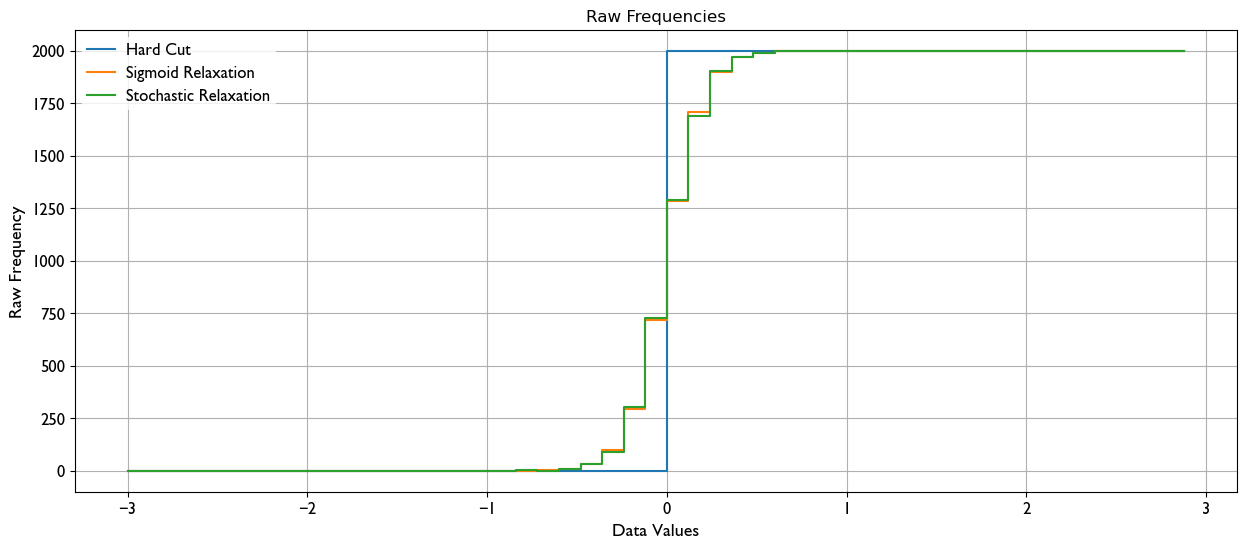

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

# Left plot: Raw frequencies
bins = jnp.linspace(-3, 3, 51)
hard_cut_counts, hard_cut_bins = jnp.histogram(hard_cut_result, bins=bins)
ax1.plot(hard_cut_bins[:-1], hard_cut_counts, label="Hard Cut", drawstyle="steps-post")

sigmoid_counts, sigmoid_bins = jnp.histogram(sigmoid_result, bins=bins, weights=sigmoid_weights)
ax1.plot(sigmoid_bins[:-1], sigmoid_counts, label="Sigmoid Relaxation", drawstyle="steps-post")

stochastic_counts, stochastic_bins = jnp.histogram(stochastic_result, bins=bins)
ax1.plot(stochastic_bins[:-1], stochastic_counts, label="Stochastic Relaxation", drawstyle="steps-post")

ax1.set_xlabel("Data Values")
ax1.set_ylabel("Raw Frequency")
ax1.legend(fontsize=10)
ax1.grid(True)
ax1.set_title("Raw Frequencies")

apply_gill_sans_font(ax1, legloc="upper left")

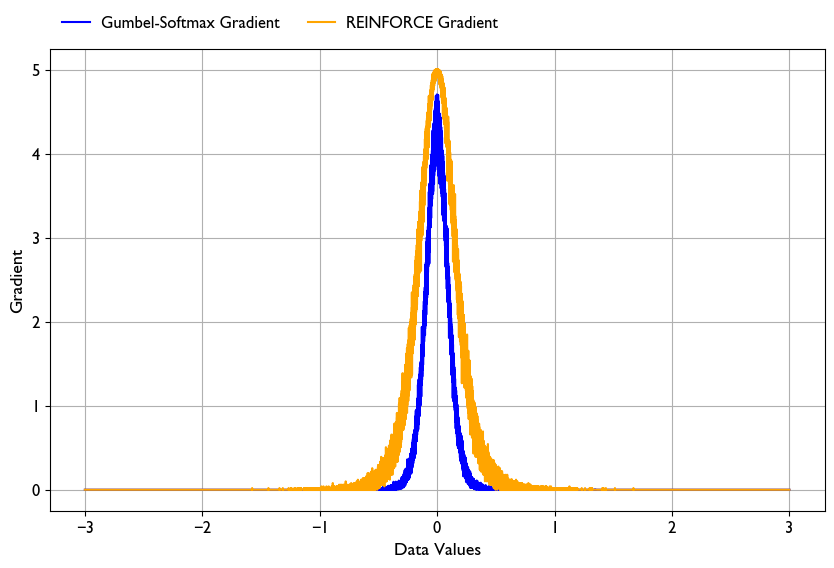

In [16]:
# Gradient comparison
config_gumbel = GumbelSoftmaxConfig(temperature=0.5, num_samples=500, use_straight_through_estimator=True)
config_reinforce = ReinforceConfig(num_samples=1000, use_baseline=True)
state_reinforce = ReinforceState()

gradient_gumbel = gumbel_softmax_gradient(problem, data, config=config_gumbel)
gradient_reinforce = reinforce_gradient(problem, data, config=config_reinforce, state=state_reinforce)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data, gradient_gumbel, label="Gumbel-Softmax Gradient", color="blue")
ax.plot(data, gradient_reinforce, label="REINFORCE Gradient", color="orange")

ax.set_xlabel("Data Values")
ax.set_ylabel("Gradient")
ax.legend(fontsize=10, ncols=3)
ax.grid(True)
apply_gill_sans_font(ax)
plt.show()

In [17]:
# Debugging frequency discrepancy
print("Total number of events with continious relaxation:", jnp.sum(sigmoid_weights))
print("Total number of events with stochastic relaxation:", len(stochastic_result))

Total number of events with continious relaxation: 50000.00000000001
Total number of events with stochastic relaxation: 50005
